### Here, we combine the training data from the four states WI, MA, GA and NC and create a combined model
- We consider the OLS linear regression, Adaboost, Random forest and xgboost models.
- We also perform some hyperparameter tuning on the xgboost model.
- The best hyperparameters: n_estimators = 800, max_depth = 3 and learning_rate = 0.1
- We do PCA with n-components=0.95 to this hyperparameter tuned model to create another model.
- PCA(n-components=0.95) reduces 17 features to 9 principal components
### Summarizing RMSE's on 5-Fold cross-validation of the various models:
- Baseline ("take average and call it a day" model): 19.422919954581346
- OLS linear regression (sklearn): 14.815524242019233
- Adaboost model (sklearn): 13.455184023547824
- Random forest model (sklearn): 11.343374248374273
- Xgboost model (w/o hyperparameter tuning): 10.993957032947407
- Xgboost model (with hyperparameter tuning): 10.582134985301789
- Xgboost model (hyperparameter tuning + PCA): 11.17041739933443
### Summarizing $R^2$-score on 5-fold cross-validation of the various models
- Baseline ("take average and call it a day" model): 0
- OLS linear regression (sklearn): 0.43643944317214933
- Adaboost model (sklearn): 0.5195882602718072
- Random forest model (sklearn): 0.6577929698755585
- Xgboost model (w/o hyperparameter tuning): 0.6790172889357701
- Xgboost model (with hyperparameter tuning): 0.702033733034167
- Xgboost model (hyperparameter tuning + PCA): 0.6680015374876783
### Top five features according to SHAP, with their mean |SHAP_value| on the hyperparameters tuned xgboost model:
- Per capita income: 12.489410
- closest_five_landgrnt_avg: 2.462371
- Population: 2.270999
- closest_five_avg_enrollment_private_nfp: 1.626570
- closest_five_private_nfp_avg: 1.478548
### We choose the xgboost model with PCA as our final model because it's performance is almost as good as the xgboost model without PCA, but potentially more efficient because of the reduction of the features. Then we run our final model on the testing data:
- RMSE on testing data: 9.313709891267006
- $R^2$-score on testing data: 0.7691986208145647
- Surprisingly, the model performed better on the testing data than on cross-validation.

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [254]:
wi_training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')
ma_training = pd.read_csv('data/Massachusetts/train_test_split/training.csv')
ga_training = pd.read_pickle('data/GA_pickled/training.pkl')
nc_training = pd.read_csv('data/North_Carolina/train_test_split/training.csv')

In [255]:
wi_training.insert(loc=1,column='State',value='WI')
ma_training.insert(loc=1,column='State',value='MA')
ga_training.insert(loc=1,column='State',value='GA')
nc_training.insert(loc=1,column='State',value='NC')

In [256]:
features = list(wi_training.columns[10:])
relevantcolumns = ['State','COUNTY','PERCENT_3_OR_ABOVE']+features
len(relevantcolumns)

20

In [257]:
ga_training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant','closest_five_landgrant_avg':'closest_five_landgrnt_avg','closest_five_avg_enrollment_landgrant':'closest_five_avg_enrollment_landgrnt'},inplace=True)

In [258]:
ga_training.columns

Index(['SCHOOL_DSTRCT_NM', 'State', 'TEST_CMPNT_TYP_NM', 'EXAM_COUNT',
       'EXAMS_3_OR_ABOVE', 'Year', 'PERCENT_3_OR_ABOVE', 'COUNTY', 'Latitude',
       'Longitude', 'population', 'closest_five_r1r2_avg',
       'closest_five_public_avg', 'closest_five_private_nfp_avg',
       'closest_five_landgrnt_avg', 'closest_five_stem_avg',
       'closest_five_avg_enrollment_r1r2',
       'closest_five_avg_enrollment_public',
       'closest_five_avg_enrollment_private_nfp',
       'closest_five_avg_enrollment_landgrnt',
       'closest_five_avg_enrollment_stem', 'closest_five_avg_dormrooms_r1r2',
       'closest_five_avg_dormrooms_public',
       'closest_five_avg_dormrooms_private_nfp',
       'closest_five_avg_dormrooms_landgrant',
       'closest_five_avg_dormrooms_stem', 'per_capita_income'],
      dtype='object')

In [259]:
nc_training.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [260]:
wi_training=wi_training[relevantcolumns]
ma_training=ma_training[relevantcolumns]
ga_training=ga_training[relevantcolumns]
nc_training=nc_training[relevantcolumns]

In [261]:
nc_training=nc_training[nc_training['PERCENT_3_OR_ABOVE'] != '*']

In [262]:
nc_training=nc_training.dropna()

In [263]:
training = pd.concat([wi_training,ma_training,ga_training,nc_training],axis=0)

**Combining the training data from the four states, we create the training data for the combined model.**

In [264]:
dummies = pd.get_dummies(training['State'])
training['Is_GA'] = dummies['GA']*1
training['Is_MA']=dummies['MA']*1
training['Is_WI']=dummies['WI']*1
features = features + ['Is_GA','Is_MA','Is_WI']

In [265]:
len(features)

20

In [266]:
training = training.apply(pd.to_numeric, errors='coerce')

In [267]:
training

,State,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,...,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem,Is_GA,Is_MA,Is_WI
0,NaN,NaN,58.508604,65586.0,52266.0,102.934660,49.119866,54.126134,149.798787,93.728419,...,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6,0,0,1
1,NaN,NaN,42.187500,16631.0,42307.0,93.067423,37.142154,30.704517,165.243556,91.579850,...,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2,0,0,1
2,NaN,NaN,59.333333,23688.0,49996.0,96.378027,36.954639,42.626467,159.078732,94.292621,...,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6,0,0,1
3,NaN,NaN,75.934136,90998.0,83681.0,62.268640,26.951514,18.219438,147.796071,47.660966,...,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4,0,0,1
4,NaN,NaN,68.906752,91613.0,86875.0,62.268640,26.951514,18.219438,147.796071,47.660966,...,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,NaN,NaN,27.857143,34162.0,41064.0,130.978467,37.441652,51.592932,209.755539,130.978467,...,24885.2,29550.8,7599.6,466.6,484.0,6909.0,7599.6,0,0,0
378,NaN,NaN,65.241295,227214.0,49313.0,91.741941,29.883256,24.596159,183.714823,91.741941,...,24885.2,22496.4,6242.6,1207.8,524.6,6909.0,6242.6,0,0,0
379,NaN,NaN,56.060606,99799.0,40777.0,129.024685,33.206873,39.224774,197.321227,129.024685,...,24107.2,25475.8,5874.8,0.0,835.4,6481.0,5874.8,0,0,0
381,NaN,NaN,39.528024,133194.0,36523.0,81.968651,35.631862,26.026482,186.518615,81.968651,...,20040.2,25378.6,7509.2,2406.6,595.2,6174.4,7509.2,0,0,0


In [268]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

In [269]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import joblib
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

N_CORES = joblib.cpu_count(only_physical_cores=True)

In [270]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for Adaboost model
    dtree_reg = DecisionTreeRegressor(max_depth=4)

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

    ada_reg.fit(train_data[features], train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], ada_reg.predict(holdout_data[features]))
    rsquared[1, i] = ada_reg.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for Random Foret model
    random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
    random_forest.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))

    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    full_lr.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[4, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], full_lr.predict(holdout_data[features]))
    rsquared[4, i] = full_lr.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    

    i = i+1


[0]	train-rmse:16.25384	validation-rmse:16.16265
[10]	train-rmse:8.36695	validation-rmse:11.42144
[20]	train-rmse:6.95328	validation-rmse:10.76229
[30]	train-rmse:6.00070	validation-rmse:10.61820
[40]	train-rmse:5.50961	validation-rmse:10.60144
[50]	train-rmse:5.11758	validation-rmse:10.62694
[60]	train-rmse:4.87655	validation-rmse:10.62420
[70]	train-rmse:4.70642	validation-rmse:10.68388
[80]	train-rmse:4.58622	validation-rmse:10.78972
[90]	train-rmse:4.52104	validation-rmse:10.80755
[100]	train-rmse:4.47082	validation-rmse:10.86091
[110]	train-rmse:4.43456	validation-rmse:10.89133
[120]	train-rmse:4.40952	validation-rmse:10.90765
[130]	train-rmse:4.38772	validation-rmse:10.91970
[140]	train-rmse:4.36977	validation-rmse:10.92661
[143]	train-rmse:4.36450	validation-rmse:10.92563
[0]	train-rmse:16.16883	validation-rmse:17.39175
[10]	train-rmse:8.42893	validation-rmse:12.54486
[20]	train-rmse:6.62063	validation-rmse:11.77030
[30]	train-rmse:5.81565	validation-rmse:11.55467
[40]	train-rms

In [271]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Adaboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Random forest model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 19.422919954581346 and STD: 0.3935405093605182
Adaboost model Avg. CV RMSE: 13.455184023547824 and STD: 0.35545956328656686
xgboost model Avg. CV RMSE: 10.993957032947407 and STD: 0.5032934940827597
Random forest model Avg. CV RMSE: 11.343374248374273 and STD: 0.7192256001115305
fullmodel Avg. CV RMSE: 14.815524242019233 and STD: 0.4982113218152422


In [272]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Adaboost Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Random forest model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")
print(f"fullmodel Avg. CV score: {np.mean(rsquared[4,:])} and STD: {np.std(rsquared[4,:])}")

Baseline Avg. CV score: -0.0005129382701796192 and STD: 0.0006651235446182674
Adaboost Avg. CV score: 0.5195882602718072 and STD: 0.019562527063465757
Xgboost model Avg. CV score: 0.6790172889357701 and STD: 0.024676397708524464
Random forest model Avg. CV score: 0.6577929698755585 and STD: 0.038183960049873365
fullmodel Avg. CV score: 0.41756569014812506 and STD: 0.02863892678844575


### Xgboost works the best on the combined model. But random forest is not far behind.

In [273]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [274]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 800

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_old_model = xgb.train(
params=params,
dtrain=dtrain_reg,
num_boost_round=n,
evals=evals,
verbose_eval=10,            # Print rmse val every 10 rounds
early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)
## This model is created before any hyperparameters tuning. So we name it as 'xgb_old_model'

[0]	train-rmse:16.25384	validation-rmse:16.16265


[10]	train-rmse:8.36695	validation-rmse:11.42144
[20]	train-rmse:6.95328	validation-rmse:10.76229
[30]	train-rmse:6.00070	validation-rmse:10.61820
[40]	train-rmse:5.50961	validation-rmse:10.60144
[50]	train-rmse:5.11758	validation-rmse:10.62694
[60]	train-rmse:4.87655	validation-rmse:10.62420
[70]	train-rmse:4.70642	validation-rmse:10.68388
[80]	train-rmse:4.58622	validation-rmse:10.78972
[90]	train-rmse:4.52104	validation-rmse:10.80755
[100]	train-rmse:4.47082	validation-rmse:10.86091
[110]	train-rmse:4.43456	validation-rmse:10.89133
[120]	train-rmse:4.40952	validation-rmse:10.90765
[130]	train-rmse:4.38772	validation-rmse:10.91970
[140]	train-rmse:4.36977	validation-rmse:10.92661
[144]	train-rmse:4.36367	validation-rmse:10.93110


# Hyperparameters tuning for xgboost model

In [275]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [276]:
model=xgb.XGBRegressor(objective= 'reg:squarederror',seed = 0)
hyperparameter_grid = {"max_depth":    [1, 3, 6, 9],
              "n_estimators": [100,200,400,600,800,1000],
              "learning_rate": [0.01, 0.05,0.1, 0.2, 1]}
gridsearch = GridSearchCV(
    estimator=model,
    param_grid=hyperparameter_grid,
    scoring='r2',
    n_jobs=10,
    cv=7,
    verbose=3)


**Because it takes long time to run the following code cell, we have commented out the code. Uncomment it to run it again.**

In [277]:
#gridsearch.fit(X_train, y_train)

**Alternatively, one can use `RandomizedSearchCV` for hyperparameter tuning. It will work faster, but at the tradeoff of not going through all given possibilities (so might not return the absolute optimal hyperparameters).**

In [278]:
#hyperparam = gridsearch.best_params_
print("The best Hyperparameters for XGBRegressor are: {}".format(hyperparam))

The best Hyperparameters for XGBRegressor are: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}


**optimal learning_rate = 0.05, max_depth = 3, n_estimators = 1000. We will use these parameters next time we train.**

# Next, let us see if PCA makes our model more efficient or if we drastically lose performance.

In [279]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [280]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(train[features])
training_scaled.shape

(1533, 20)

In [281]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)
training_pca.shape

(1533, 10)

In [282]:
xgb_pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('xgb_model', xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror'))])

In [283]:
xgb_pca_pipe.fit(train[features],train['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [284]:
xgb_pca_preds = xgb_pca_pipe.predict(validation[features])
print(root_mean_squared_error(xgb_pca_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_pca_preds,multioutput='variance_weighted'))

11.602738225551262
0.617572723082916


In [285]:
xgb_new_model = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror')
xgb_new_model.fit(train[features],train['PERCENT_3_OR_ABOVE'])
xgb_new_preds = xgb_new_model.predict(validation[features])
print(root_mean_squared_error(xgb_new_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_new_preds,multioutput='variance_weighted'))

10.853183931519931
0.6653874702463503


In [286]:
xgb_old_preds = xgb_old_model.predict(dtest_reg)
print(root_mean_squared_error(xgb_old_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_old_preds,multioutput='variance_weighted'))

10.931102160843821
0.6605656581772583


### Our hyperparameter-tuned model is clearly better than the older model in terms of root mean squared error and the PCA(0.95) model is marginally behind of our old model. Analogous conclusion can be obtained from the R-squared values.
### Let us further test with 5-Fold cross validation.

In [287]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for new hyperparameter tuned xgboost model
    xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror')
    xgb_model.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_model.predict(holdout_data[features]))
    xgb_preds = xgb_model.predict(holdout_data[features])
    rsquared[1, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'],xgb_preds)
    
    
    ## Fit and get ho mse for old (not hyperparameter tuned) xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_old_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_old_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred,multioutput='variance_weighted')

    
    ## Fit and get ho mse for xgb PCA(0.95) model with hyperparameter tuning
    xgb_pca_pipe = Pipeline([('scale', StandardScaler()), 
                             ('pca', PCA(0.95)), (
                                 'xgb_model', xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror'))])
    xgb_pca_pipe.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))

    

    i = i+1

[0]	train-rmse:16.25384	validation-rmse:16.16265
[10]	train-rmse:8.36695	validation-rmse:11.42144
[20]	train-rmse:6.95328	validation-rmse:10.76229
[30]	train-rmse:6.00070	validation-rmse:10.61820
[40]	train-rmse:5.50961	validation-rmse:10.60144
[50]	train-rmse:5.11758	validation-rmse:10.62694
[60]	train-rmse:4.87655	validation-rmse:10.62420
[70]	train-rmse:4.70642	validation-rmse:10.68388
[80]	train-rmse:4.58622	validation-rmse:10.78972
[90]	train-rmse:4.52104	validation-rmse:10.80755
[100]	train-rmse:4.47082	validation-rmse:10.86091
[110]	train-rmse:4.43456	validation-rmse:10.89133
[120]	train-rmse:4.40952	validation-rmse:10.90765
[130]	train-rmse:4.38772	validation-rmse:10.91970
[140]	train-rmse:4.36977	validation-rmse:10.92661
[144]	train-rmse:4.36367	validation-rmse:10.93110
[0]	train-rmse:16.16883	validation-rmse:17.39175
[10]	train-rmse:8.42893	validation-rmse:12.54486
[20]	train-rmse:6.62063	validation-rmse:11.77030
[30]	train-rmse:5.81565	validation-rmse:11.55467
[40]	train-rms

In [288]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"Old xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 19.422919954581346 and STD: 0.3935405093605182
Hyperparameter tuned xgboost model Avg. CV RMSE: 10.582134985301789 and STD: 0.5995524859512588
Old xgboost model Avg. CV RMSE: 10.993957032947407 and STD: 0.5032934940827597
Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: 11.17041739933443 and STD: 0.5221815278201358


In [289]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Old Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV score: -0.0005129382701796192 and STD: 0.0006651235446182674
Hyperparameter tuned xgboost model Avg. CV score: 0.702033733034167 and STD: 0.03248695400997866
Old Xgboost model Avg. CV score: 0.6790172889357701 and STD: 0.024676397708524464
Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: 0.6680015374876783 and STD: 0.033404731903448684


### The hyperparameter tuned model is certainly the beest. But PCA(0.95) does not fall behind in performance by much.

### We save our new hyperparameters tuned xgboost model as a pickle file.

In [290]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror')
xgb_model.fit(training[features],training['PERCENT_3_OR_ABOVE'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [291]:
import joblib
from joblib import Parallel, delayed

## Save the xgboost model as a pickled file.

#joblib.dump(xgb_model, 'data/Four_states_combined_models_pickled/four_states_combined_xgboost_model.pkl')

### Since the PCA model after hyperparameter tuning is also not far behind, we save it as well as a pickle file.

In [292]:
xgb_pca_pipe = Pipeline([('scale', StandardScaler()), 
                             ('pca', PCA(0.95)), (
                                 'xgb_model', xgb.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.05,objective= 'reg:squarederror'))])
xgb_pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

**Since the PCA reduces the number of features to half (20 to 10), so we expect it to be more efficient, even if it performs slightly worse. Moreover, it might also reduce the issue of overfitting.**

In [293]:
## Save the xgboost model with PCA as a pickle file.

#joblib.dump(xgb_pca_pipe, 'data/Four_states_combined_models_pickled/four_states_combined_xgboost_pca_model.pkl')

### **In spite of being slightly behind in performance, since PCA xgboost model reduces the number of features considerably, we expect it to be more efficient. Also, reducing the number of features to functionally independent ones will potentially reduce the possibility of overfitting. So, we choose it as our final model.**

# SHAP to interpret our models and feature importance

In [294]:
import shap
import pickle

### SHAP doesn't seem to support Pipeline. So, let's look at the hyperparameter tuned xgboost model instead

In [295]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [296]:
# Compute mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from SHAP:\n")
print(shap_importance)

Feature Importance from SHAP:

                                    Feature  Importance
1                         per_capita_income   12.489410
5                 closest_five_landgrnt_avg    2.462371
0                                population    2.270999
9   closest_five_avg_enrollment_private_nfp    1.626570
4              closest_five_private_nfp_avg    1.478548
10     closest_five_avg_enrollment_landgrnt    1.439954
14   closest_five_avg_dormrooms_private_nfp    1.288311
3                   closest_five_public_avg    1.272025
7          closest_five_avg_enrollment_r1r2    1.228849
12          closest_five_avg_dormrooms_r1r2    1.156774
6                     closest_five_stem_avg    0.976317
2                     closest_five_r1r2_avg    0.894231
8        closest_five_avg_enrollment_public    0.853246
11         closest_five_avg_enrollment_stem    0.638011
13        closest_five_avg_dormrooms_public    0.588985
15     closest_five_avg_dormrooms_landgrant    0.438390
16          close

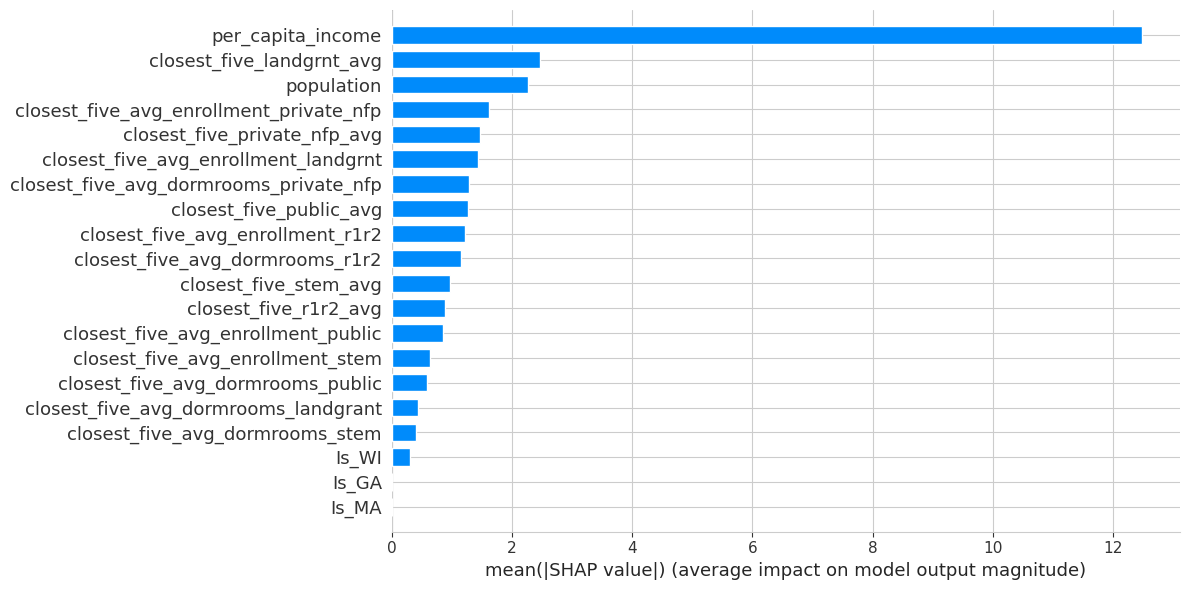

In [ ]:
fig = plt.figure()
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
#with open('data/Four_states_combined_models_pickled/shap_xgb_hypertuned_bar_plot.pkl', 'wb') as f:
    #pickle.dump(fig, f)
plt.close()

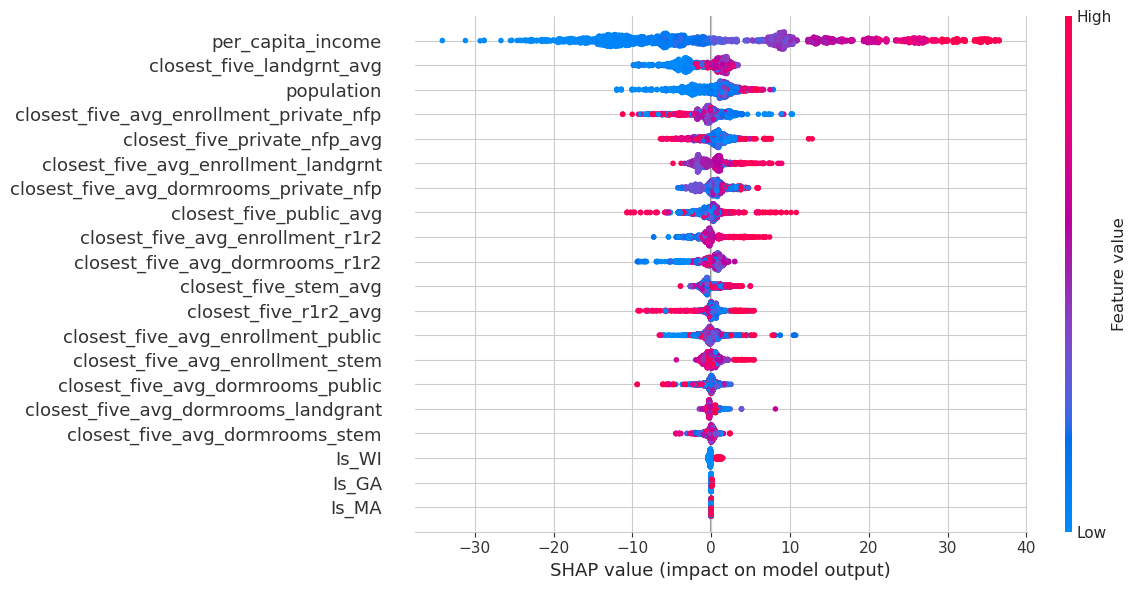

In [ ]:
### the scatter plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
#with open('data/Four_states_combined_models_pickled/shap_xgb_hypertuned_scatter_plot.pkl', 'wb') as f:
    #pickle.dump(fig, f)
plt.close()

# Running the model on the testing data

In [299]:
wi_testing = pd.read_csv('data/Wisconsin/train_test_split/testing.csv')
ma_testing = pd.read_csv('data/Massachusetts/train_test_split/testing.csv')
ga_testing = pd.read_pickle('data/GA_pickled/testing.pkl')
nc_testing = pd.read_csv('data/North_Carolina/train_test_split/testing.csv')

In [300]:
ga_testing.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant','closest_five_landgrant_avg':'closest_five_landgrnt_avg','closest_five_avg_enrollment_landgrant':'closest_five_avg_enrollment_landgrnt'},inplace=True)

In [301]:
nc_testing.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [302]:
wi_testing.insert(loc=1,column='State',value='WI')
ma_testing.insert(loc=1,column='State',value='MA')
ga_testing.insert(loc=1,column='State',value='GA')
nc_testing.insert(loc=1,column='State',value='NC')

In [303]:
wi_testing=wi_testing[relevantcolumns]
ma_testing=ma_testing[relevantcolumns]
ga_testing=ga_testing[relevantcolumns]
nc_testing=nc_testing[relevantcolumns]

In [304]:
len(nc_testing.index)

96

In [305]:
len(nc_training.index)

322

In [306]:
nc_testing=nc_testing[nc_testing['PERCENT_3_OR_ABOVE'] != '*']

In [307]:
nc_testing=nc_testing.dropna()

In [308]:
testing = pd.concat([wi_testing,ma_testing,ga_testing,nc_testing],axis=0)

**By combining the testing data for each of the four states, we obtain the testing data for the combined model**

In [309]:
testing

,State,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,WI,Jefferson,63.51626,84696.0,47305,56.513411,25.692136,21.083706,154.787748,46.737344,27064.0,19050.4,1825.6,30937.0,22189.6,5303.4,2643.4,534.0,7594.4,4480.6
1,WI,Waushara,43.956044,24549.0,43781,117.003936,43.076829,49.409389,137.690816,103.671360,27064.0,10705.2,2084.0,22515.6,22189.6,5303.4,1036.2,953.2,3257.0,4480.6
2,WI,Oneida,65.202703,37118.0,48517,175.279031,54.345122,107.755170,118.141501,172.229021,32411.8,3509.2,1136.8,10172.6,24446.6,5696.8,56.6,797.0,1794.2,3910.4
3,WI,Lincoln,62.0,28376.0,53038,165.715335,44.102369,104.584718,117.385571,161.474822,32411.8,5166.0,1202.8,10172.6,24446.6,5696.8,588.4,951.8,1794.2,3910.4
4,WI,Rock,58.988764,163681.0,45500,59.757422,23.670589,24.512027,157.561949,54.971126,27064.0,18882.4,1110.0,30937.0,22189.6,5303.4,2643.4,455.8,7594.4,4480.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NC,Polk,66.6666667,19351.0,47268.0,137.926921,28.720862,37.577446,183.704575,137.926921,30033.8,5018.6,1433.2,24107.2,30033.8,6650.8,178.2,814.4,6481.0,6650.8
92,NC,Caswell,28.4090909,22895.0,33986.0,62.868823,35.830309,44.543495,155.919760,62.868823,25378.6,5671.8,5682.0,20651.4,25378.6,7509.2,1117.4,2293.6,5957.4,7509.2
93,NC,Buncombe,55,264585.0,47569.0,137.053060,23.003519,32.158670,191.176648,137.053060,30916.8,4962.4,1328.8,31226.8,30916.8,6860.6,332.2,858.8,8084.4,6860.6
94,NC,Greene,22.2222222,20475.0,32551.0,105.888467,29.166925,61.390015,231.517761,105.888467,28576.2,10981.4,1548.4,20131.4,28576.2,7345.4,1128.0,596.0,6243.2,7345.4


In [310]:
dummies = pd.get_dummies(testing['State'])
testing['Is_GA'] = dummies['GA']*1
testing['Is_MA']=dummies['MA']*1
testing['Is_WI']=dummies['WI']*1

In [311]:
features

['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_avg_dormrooms_public',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_avg_dormrooms_landgrant',
 'closest_five_avg_dormrooms_stem',
 'Is_GA',
 'Is_MA',
 'Is_WI']

In [312]:
testing = testing.apply(pd.to_numeric, errors='coerce')

In [313]:
testing

,State,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,...,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem,Is_GA,Is_MA,Is_WI
0,NaN,NaN,63.516260,84696.0,47305.0,56.513411,25.692136,21.083706,154.787748,46.737344,...,30937.0,22189.6,5303.4,2643.4,534.0,7594.4,4480.6,0,0,1
1,NaN,NaN,43.956044,24549.0,43781.0,117.003936,43.076829,49.409389,137.690816,103.671360,...,22515.6,22189.6,5303.4,1036.2,953.2,3257.0,4480.6,0,0,1
2,NaN,NaN,65.202703,37118.0,48517.0,175.279031,54.345122,107.755170,118.141501,172.229021,...,10172.6,24446.6,5696.8,56.6,797.0,1794.2,3910.4,0,0,1
3,NaN,NaN,62.000000,28376.0,53038.0,165.715335,44.102369,104.584718,117.385571,161.474822,...,10172.6,24446.6,5696.8,588.4,951.8,1794.2,3910.4,0,0,1
4,NaN,NaN,58.988764,163681.0,45500.0,59.757422,23.670589,24.512027,157.561949,54.971126,...,30937.0,22189.6,5303.4,2643.4,455.8,7594.4,4480.6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,66.666667,19351.0,47268.0,137.926921,28.720862,37.577446,183.704575,137.926921,...,24107.2,30033.8,6650.8,178.2,814.4,6481.0,6650.8,0,0,0
92,NaN,NaN,28.409091,22895.0,33986.0,62.868823,35.830309,44.543495,155.919760,62.868823,...,20651.4,25378.6,7509.2,1117.4,2293.6,5957.4,7509.2,0,0,0
93,NaN,NaN,55.000000,264585.0,47569.0,137.053060,23.003519,32.158670,191.176648,137.053060,...,31226.8,30916.8,6860.6,332.2,858.8,8084.4,6860.6,0,0,0
94,NaN,NaN,22.222222,20475.0,32551.0,105.888467,29.166925,61.390015,231.517761,105.888467,...,20131.4,28576.2,7345.4,1128.0,596.0,6243.2,7345.4,0,0,0


In [314]:
model_preds = xgb_pca_pipe.predict(testing[features])

In [315]:
root_mean_squared_error(testing['PERCENT_3_OR_ABOVE'],model_preds)

np.float64(9.313709891267006)

In [316]:
r2_score(testing['PERCENT_3_OR_ABOVE'],model_preds)

0.7691986208145647